In [288]:
import fastbook
fastbook.setup_book()
from fastbook import *
from fastai.vision.widgets import *
import skimage
from skimage import io as skio
import numpy
from PIL import ImageEnhance
path =Path("D:/pytorch/data/2D_FishAge")
Path.BASE_PATH =path
image_list = (path/'images').ls()

In [6]:
#Potential problem here, the 16bit images is squished into a narrow float range before being normalized out to 0-1
#Attempting to use tensors for speed when scaling to 3D GB data

#added - add 3 columns and reshape to a 3channel image to make it easier to use with the fastai model batching
image_tensors = [tensor(skimage.img_as_float( np.transpose( np.repeat( np.asarray(Image.open(o))[:, :, np.newaxis], 3, axis=2), (2,0,1)) )) for o in image_list]
#normalize the dataset to min-max
stacked_images_tensor = torch.stack(image_tensors)
stacked_images_tensor.shape
max = torch.max(stacked_images_tensor)
min = torch.min(stacked_images_tensor)
#considering min*0.98 and max*0.98 to reduce error from speckles
normal_stacked_images_tensor = (stacked_images_tensor-min)/(max-min)
# df = pd.DataFrame(image1_tensor)
# df.style.set_properties(**{'font-size':'6pt'}).background_gradient('Greys')

##########################################
## Replace this all with a better dataloader
## Requires dummy files to be in place in the images folder
## ADD TO TFMS??https://forums.fast.ai/t/how-to-use-segmentationdataloaders-correctly/88226/11
#########################################

numpy_array = [(o.numpy()*255).astype(numpy.uint8) for o in normal_stacked_images_tensor]

from tifffile import imsave
image_list_output = (path/'images').ls()
zippy = zip(image_list_output, (numpy_array))
#list(zippy)
[imsave(str(a),b) for a,b in zippy]

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,

In [163]:
fnames = get_image_files(path/"images")


In [164]:
print(fnames[20])
get_time_hrs(fnames[20])


D:\pytorch\data\2D_FishAge\images\S000_t000001_V000_R0001_X000_Y000_C02_I0_D0_P00302_MP.tif


5.25

In [165]:
#minutes between time points
minutes=15
fnames = get_image_files(path/"images")
def name_to_hrs (r): return float(round(float(os.path.basename(r)[0:-4].split("_")[1][1:])*(minutes/60)+5,2))
def validation_split (r):  return os.path.basename(r)[0:-4].split("_")[3] == "R0003" or os.path.basename(r)[0:-4].split("_")[3] == "R0006"
dblock = DataBlock(blocks=(ImageBlock, RegressionBlock),
                  get_items = get_image_files,
                  get_y= name_to_hrs,
                  splitter = FuncSplitter(validation_split),
                  batch_tfms =aug_transforms(size=(512,512))
                  )
dls = dblock.dataloaders(path)

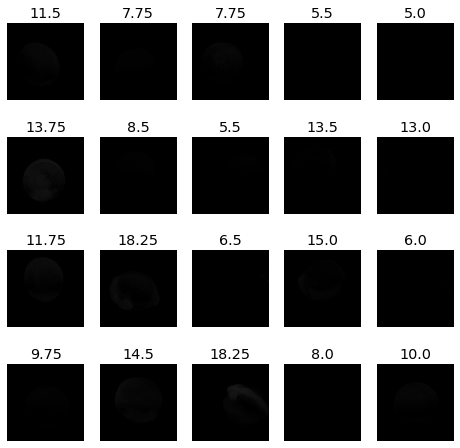

In [171]:

dls.show_batch(max_n=20, figsize=(8,8))

In [169]:
learn = vision_learner(dls, resnet18, y_range=(4.9,24)).to_fp16()

In [104]:
learn.lr_find()

KeyboardInterrupt: 

In [201]:
lr = 1e-2
learn.fine_tune(50, lr)

epoch,train_loss,valid_loss,time
0,48.433117,153.587830,00:05


epoch,train_loss,valid_loss,time
0,37.439404,78.538818,00:05
1,37.109306,37.399311,00:05
2,34.112064,18.357538,00:05
3,28.848789,5.891658,00:05
4,23.333544,13.346997,00:05
5,18.433661,3.037339,00:05
6,14.922066,3.377725,00:05
7,11.948373,5.541417,00:05
8,9.905044,5.547775,00:05
9,8.352984,1.364758,00:05


In [202]:
learn.to_fp32()
learn.unfreeze
learn.fit_one_cycle(50, lr_max=slice(1e-6, 2e-3))

epoch,train_loss,valid_loss,time
0,1.379178,1.205279,00:07
1,1.275995,1.299855,00:07
2,1.271877,1.272103,00:07
3,1.482968,1.396263,00:07
4,1.399666,1.078531,00:07
5,1.346114,1.194538,00:07
6,1.288684,1.462310,00:07
7,1.275941,1.327459,00:07
8,1.314818,1.762316,00:07
9,1.262996,0.828288,00:07


In [211]:
learn.export('export.pkl')

In [210]:
learn.path = Path("D:/pytorch/data/2D_FishAge")

In [212]:
zebrafish_age_predictor = load_learner(path/'export.pkl')


S000_t000056_V000_R0017_X000_Y000_C02_I0_D0_P00351_MP.tif


Estimated age is 18.36hrs.


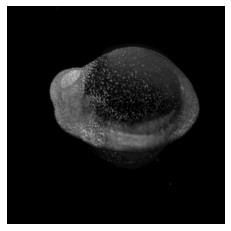

In [248]:
n=1080
print(os.path.basename(fnames[n]))
img = plt.imread(fnames[n])
age,tensor, tensor=zebrafish_age_predictor.predict(img)
print("Estimated age is "+str(round(age[0],2))+"hrs.")
plt.figure(figsize=(4,4))

plt.axis('off')
plt.imshow(img*10)


In [281]:

out_pl = widgets.Output()
lbl_pred = widgets.Label()
zebrafish_age_predictor = load_learner(path/'export.pkl')
btn_run = widgets.Button(description='Process')
def on_click_classify(change):
    img = PILImage.create(btn_upload.data[-1])
    out_pl.clear_output()
    enhancer = ImageEnhance.Brightness(img)
    factor = 10 
    im_output = enhancer.enhance(factor)
    with out_pl: display(im_output.to_thumb(128,128))
    age,tensor, tensor=zebrafish_age_predictor.predict(img)
    lbl_pred.value = f'Predicted age: {age[0]};'

btn_run.on_click(on_click_classify)

In [286]:
btn_upload= widgets.FileUpload()

In [287]:
VBox([widgets.Label('Upload a grayscale zebrafish embryo image'), 
      btn_upload, btn_run, out_pl, lbl_pred])

In [252]:
zebrafish_age_predictor.predict(img)

((18.362674713134766,), TensorBase([18.3627]), TensorBase([18.3627]))